In [4]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

import sys
from os.path import join as oj

sys.path.append("../src")
from utils import load_precalculated_dataset,get_output, load_img_dataset,get_auc_f1,calc_weights
import numpy as np
from torchvision import  transforms
import pickle as pkl

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from numpy.random import randint
import time
from torchvision import models
import copy
from tqdm import tqdm
from torch import nn
import pandas as pd
import seaborn as sns
sns.set()
import torch.nn.functional as F
from PIL import Image
import torch
device = torch.device("cuda")
pd.set_option('display.precision', 2)


In [6]:
save_path = "../results_for_export"
trained_model_folder = '../../models/ISIC'
fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder) if 'pkl'  in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1, sort = True).T.infer_objects() 
idx_best_loss = [np.asarray(x).argmax() for x in results['val_acc_history']]  
results['final_acc'] = [x[idx_best_loss[i]] for i,x in enumerate(results['val_acc_history'])] 


A regularizer rate of -1 indicates that only images with no patches were used for training. 

In [7]:
results[['regularizer_rate',
                       'final_acc', 
                       'AUC (no patches)',
                       'F1 score (no patches)',
                       'AUC (patches)',
                       'F1 score (patches)']].groupby('regularizer_rate').mean()

final_acc  AUC (no patches)  F1 score (no patches)  \
regularizer_rate                                                       
-1.0                   0.89              0.88                   0.63   
 0.0                   0.89              0.88                   0.63   
 10.0                  0.89              0.87                   0.62   

                  AUC (patches)  F1 score (patches)  
regularizer_rate                                     
-1.0                       0.92                0.62  
 0.0                       0.94                0.63  
 10.0                      0.93                0.62

In [11]:
# take the best network for each to visualize heatmaps 
results[['regularizer_rate','AUC (patches)','pid']][results.regularizer_rate >=0].sort_values('AUC (patches)')

regularizer_rate  AUC (patches)                   pid
2               10.0           0.93  15653133524180105634
0               10.0           0.93  07147856582214574535
5               10.0           0.93  33620380500228801084
3               10.0           0.93  20100703381376783413
13               0.0           0.93  71265608625845142307
7               10.0           0.93  41856414586426253718
9                0.0           0.93  52462302701235013260
10               0.0           0.94  64810826827067867363
8                0.0           0.94  50310340673822021804
11               0.0           0.94  68508437606482830160

# Calculate ROC AUC
Needs GPU enabled

In [ ]:

datasets,_ = load_precalculated_dataset("../data/ISIC/calculated_features")
device = torch.device(0)
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device).eval()


In [ ]:
f1_nopatches_dict = {}
auc_nopatches_dict = {}
f1_patches_dict = {}
auc_patches_dict = {}
for index, row in results[['regularizer_rate','pid',]].iterrows():
    fname = oj(trained_model_folder, str(row['pid']) + '.pt')
    auc_nopatches_dict[row['pid']], f1_nopatches_dict[row['pid']] = get_auc_f1(model, datasets['test_no_patches'], fname = fname, )
    auc_patches_dict[row['pid']], f1_patches_dict[row['pid']] = get_auc_f1(model, datasets['test'], fname = fname, )
    
# update values 
results['AUC (no patches)'] =[auc_nopatches_dict[x] for x in results['pid']]
results['F1 score (no patches)'] =[f1_nopatches_dict[x] for x in results['pid']]
results['AUC (patches)'] =[auc_patches_dict[x] for x in results['pid']]
results['F1 score (patches)'] =[f1_patches_dict[x] for x in results['pid']]

# GradCAM
Needs GPU enabled

In [5]:
sys.path.append("../../pytorch-cnn-visualizations/src")
from tqdm import tqdm_notebook
from gradcam import GradCam
import torchvision.models as models
from PIL import Image
from utils import load_img_dataset

In [6]:
img_dataset = load_img_dataset("../data/ISIC/processed/") # this only loads the test set
mean = np.asarray([0.485, 0.456, 0.406]) 
std = np.asarray([0.229, 0.224, 0.225])

As the pid's are determined randomly, they need to be filled in in the following cell

In [7]:

model_no_reg = models.vgg16(pretrained=True)
model_no_reg.classifier[-1] = nn.Linear(4096, 2)
model_no_reg = model_no_reg.eval()
model_no_reg.classifier.load_state_dict(torch.load('../models/ISIC_new/18378132135284132533.pt')); # best performing vanilla model
model_reg = models.vgg16(pretrained=True)
model_reg.classifier[-1] = nn.Linear(4096, 2)
model_reg = model_reg.eval()
model_reg.classifier.load_state_dict(torch.load('../models/ISIC_new/43348406653761550146.pt')); # best performing CDEP model

In [8]:
my_list_all = [img_dataset[i][0] for i in range(1000) ]
my_list_targets_all = [img_dataset[i][1] for i in range(1000) ]

In [9]:
model_reg = model_reg.cuda()
model_no_reg = model_no_reg.cuda()

grad_cam_noreg = GradCam(model_no_reg, target_layer=29)
grad_cam_reg = GradCam(model_reg, target_layer=29)

In [10]:
triples = []
for img, target in tqdm(zip(my_list_all[:1000], my_list_targets_all[:1000])):
    img.requires_grad= True
    test_img = img.cuda()
    test_img = test_img[None, :, :224, :224]
    img_np = img[:, :224, :224].detach().cpu().numpy().transpose(1,2,0)*std[None, None, :] + mean[None, None, :]
    reg_saliency = grad_cam_reg.generate_cam(test_img, target)
    vanilla_saliency = grad_cam_noreg.generate_cam(test_img, target)
    triples.append((img_np, vanilla_saliency, reg_saliency, target))

1000it [01:04, 15.59it/s]


Visualize GradCAM for both networks to see what each model has learnt

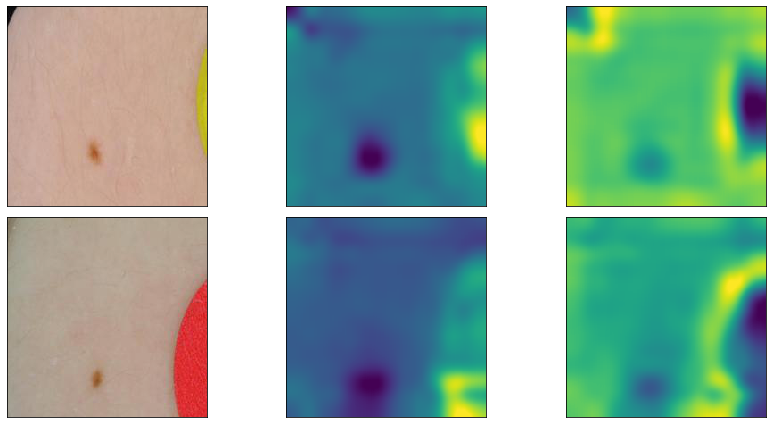

In [11]:

sns.reset_orig()
idxs = [1,2] # first ids that have a patch
num_rows = len(idxs)

fig, axes = plt.subplots(num_rows,3, figsize=  (4.2*3, num_rows*3))

for i, (idx) in enumerate(idxs):
    original_img, vanilla_sal, reg_sal, true_class = triples[idx]

    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow( vanilla_sal, cmap = plt.get_cmap("viridis"),)
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
    axes[i,2].imshow(reg_sal, cmap =plt.get_cmap("viridis"))

    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

plt.tight_layout()
save_path = "../results_for_export"
# fig.savefig(oj(save_path,"gradCAM"))

We also visualize some samples that have hairs/rulers in them

In [12]:
cancer_triples = [x for x in triples if x[3] ==1]
no_cancer_triples = [x for x in triples if x[3] ==0]

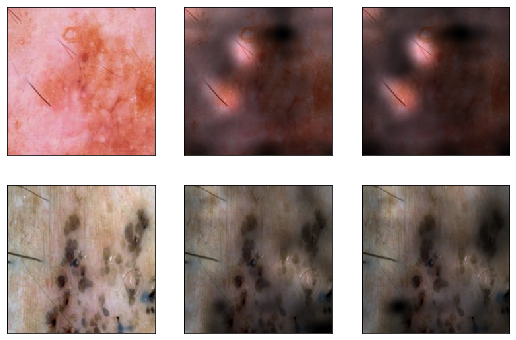

In [13]:
sns.reset_orig()
num_rows = 2
fig, axes = plt.subplots(ncols=3, nrows = num_rows, figsize=  (3*3, num_rows*3))
i_small  =0 
for i, (original_img, vanilla_sal, reg_sal, true_class) in enumerate(cancer_triples[:num_rows]):
    # highlighting works the other way around
    vanilla_sal = 1- vanilla_sal
    reg_sal = 1- reg_sal

    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow(vanilla_sal[:, :, None]*np.clip(original_img,0,1))
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,2].imshow(reg_sal[:, :, None]*np.clip(original_img,0,1))
    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
